In [1]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling1D, UpSampling1D
from keras.layers.convolutional import Conv1D, Conv2D
from keras.optimizers import SGD, Adam
import medleydb as mdb
from scipy import signal
from scipy.io import wavfile

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Load the audio data

In [3]:
multitracks = mdb.load_multitracks([
    "Phoenix_ColliersDaughter", 
    "Phoenix_BrokenPledgeChicagoReel", 
    "Phoenix_ElzicsFarewell", 
    "Phoenix_LarkOnTheStrandDrummondCastle",
    "Phoenix_ScotchMorris",
    "Phoenix_SeanCaughlinsTheScartaglen"
])

In [4]:
mix_audio = None
instrument_audio = None

for mix in multitracks:
    sample_rate, song = wavfile.read(mix.mix_path)
    
    if mix_audio is None:
        mix_audio = song
    
    else:
        mix_audio = np.concatenate((mix_audio, song))
    
    #
    
    instruments = mdb.get_files_for_instrument("violin", [mix])

    instrument = next(instruments)
    
    sample_rate, track = wavfile.read(instrument)
    
    if instrument_audio is None:
        instrument_audio = track
    
    else:
        instrument_audio = np.concatenate((instrument_audio, track))
    
mix_audio = mix_audio.mean(1)
instrument_audio = instrument_audio.mean(1)

In [5]:
samples_per_period = 256
overlap = int(samples_per_period/2)

# Process the Mix

In [6]:
freqs, times, s_mix = signal.stft(mix_audio, fs=sample_rate, nfft=samples_per_period, 
                                         noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_mix = s_mix[:-1,:]

In [7]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_mix)))
#plt.title("STFT of the Mix")
#plt.ylabel("Frequency (Hz)")
#plt.xlabel("Time (s)")

# Process the Target Instrument

In [8]:
freqs, times, s_instrument = signal.stft(instrument_audio, fs=sample_rate, nfft=samples_per_period, 
                                               noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_instrument = s_instrument[:-1,:]
s_instrument += 1e-9

In [9]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_instrument)))
#plt.title("STFT of the instrument Track")
#plt.xlabel("Time (s)")
#plt.ylabel("Frequency (Hz)")

# Prepare the training data

In [10]:
num_test  = int((sample_rate * 120)/samples_per_period)
num_train = s_mix.shape[1] - num_test
print(num_train, num_test)

374742 20671


In [11]:
mix_train = s_mix.T[:num_train,np.newaxis,:]
mix_train = np.concatenate((mix_train.real, mix_train.imag), axis=1)
mix_train.shape

(374742, 2, 128)

In [12]:
instrument_train = s_instrument.T[:num_train,np.newaxis,:]
instrument_train = np.concatenate((instrument_train.real, instrument_train.imag), axis=1)
instrument_train.shape

(374742, 2, 128)

In [13]:
mix_test = s_mix.T[-num_test:,np.newaxis,:]
mix_test = np.concatenate((mix_test.real, mix_test.imag), axis=1)
mix_test.shape

(20671, 2, 128)

In [14]:
instrument_test = s_instrument.T[-num_test:,np.newaxis,:]
instrument_test = np.concatenate((instrument_test.real, instrument_test.imag), axis=1)
instrument_test.shape

(20671, 2, 128)

In [49]:
model = Sequential()

model.add(Dense(128, input_shape=mix_train.shape[1:], activation="relu"))

model.add(Conv1D(512, 8, padding="same", activation="relu", name="Conv1D_1"))
#model.add(MaxPooling1D(2, padding="same", name="MaxPooling_1"))

model.add(Conv1D(256, 4, padding="same",  activation="relu", name="Conv1D_2"))
#model.add(MaxPooling1D(2, padding="same", name="MaxPooling_2"))

model.add(Conv1D(128, 2, padding="same",  activation="relu", name="Conv1D_3"))
#model.add(MaxPooling1D(2, padding="same", name="MaxPooling_3"))

#model.add(Dense(1024, input_shape=mix_train.shape[1:], activation="relu"))

#model.add(Conv1D(512, 2, padding="same",  activation="relu", name="Conv1D_4"))
#model.add(UpSampling1D(2, name="UpSampling_1"))

#model.add(Conv1D(256, 2, padding="same",  activation="relu", name="Conv1D_5"))
#model.add(UpSampling1D(2, name="UpSampling_2"))

#model.add(Conv1D(128, 2, padding="same",  activation="relu", name="Conv1D_6"))
#model.add(UpSampling1D(2, name="UpSampling_3"))

#model.add(Conv1D(2, 2, padding="same",  name="Conv1D_7"))

model.add(Dense(128, activation="relu"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 2, 128)            16512     
_________________________________________________________________
Conv1D_1 (Conv1D)            (None, 2, 512)            524800    
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 2, 256)            524544    
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 2, 128)            65664     
_________________________________________________________________
dense_24 (Dense)             (None, 2, 128)            16512     
Total params: 1,148,032
Trainable params: 1,148,032
Non-trainable params: 0
_________________________________________________________________


In [57]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#sgd = SGD(lr=0.001, momentum=1.1, decay=1.1, nesterov=True)

model.compile(adam, loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
history = model.fit(mix_train, instrument_train, batch_size=1000, epochs=1000)

Epoch 1/1000
374742/374742 [==============================] - 8s 22us/step - loss: 2157.9205 - acc: 0.4305
Epoch 2/1000
374742/374742 [==============================] - 7s 20us/step - loss: 2150.2524 - acc: 0.4333
Epoch 3/1000
374742/374742 [==============================] - 7s 20us/step - loss: 2142.8951 - acc: 0.4347
Epoch 4/1000
374742/374742 [==============================] - 7s 20us/step - loss: 2134.8336 - acc: 0.4364
Epoch 5/1000
374742/374742 [==============================] - 7s 20us/step - loss: 2125.9775 - acc: 0.4382
Epoch 6/1000
374742/374742 [==============================] - 7s 20us/step - loss: 2120.0371 - acc: 0.4392
Epoch 7/1000
374742/374742 [==============================] - 7s 20us/step - loss: 2114.8750 - acc: 0.4406
Epoch 8/1000
374742/374742 [==============================] - 7s 20us/step - loss: 2110.2033 - acc: 0.4415
Epoch 9/1000
374742/374742 [==============================] - 7s 20us/step - loss: 2106.0444 - acc: 0.4424
Epoch 10/1000
374742/374742 [========

In [59]:
results = model.evaluate(mix_test, instrument_test)

print(model.metrics_names)
print(results)

20671/20671 [==============================] - 1s 59us/step
['loss', 'acc']
[2683.5981626494545, 0.3992066179599917]


# Results

In [60]:
prediction = model.predict(mix_test)
prediction.shape

(20671, 2, 128)

In [61]:
prediction = (prediction[:,0,:]+prediction[:,1,:] * 1j).T
prediction += 1e-9

In [62]:
target = s_instrument[:, -num_test:]

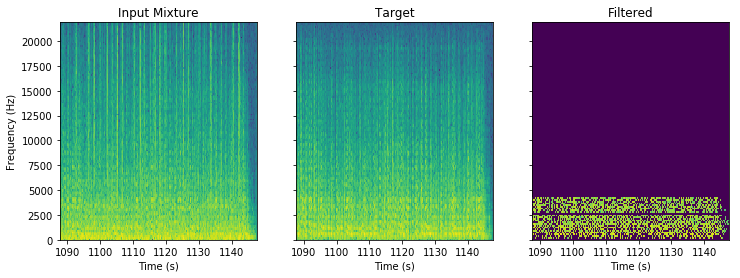

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True,figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target")
ax3.set_title("Filtered")

ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax3.set_xlabel("Time (s)")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(target)))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(prediction)))

## Let's hear it

In [ ]:
_, predicted_audio = signal.istft(prediction, fs=sample_rate)
_, target_audio = signal.istft(target, fs=sample_rate)
_, mix_audio = signal.istft(s_mix[:,-num_test:], fs=sample_rate)

wavfile.write("fcn_model_2_instrument_prediction.wav", sample_rate, predicted_audio.astype(np.int16))
wavfile.write("fcn_model_2_instrument_target.wav", sample_rate, target_audio.astype(np.int16))
wavfile.write("fcn_model_2_original.wav", sample_rate, mix_audio.astype(np.int16))